In [14]:
import warnings
warnings.filterwarnings(action="ignore")

In [13]:
import pandas as pd
import numpy as np
df=pd.read_csv("data.csv")
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [2]:
# Dividing Data and Labels
y = df['Bankrupt?']
X = df.drop(['Bankrupt?'], axis = 1)

Plan:
- t-sne & oversampling + cross val
- t-sne $undersampling + cross val

In [3]:
#splitting dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)

Logistic Regression Accuracy: 0.9626

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1317
           1       0.00      0.00      0.00        47

    accuracy                           0.96      1364
   macro avg       0.48      0.50      0.49      1364
weighted avg       0.93      0.96      0.95      1364


Confusion Matrix:
[[1313    4]
 [  47    0]]


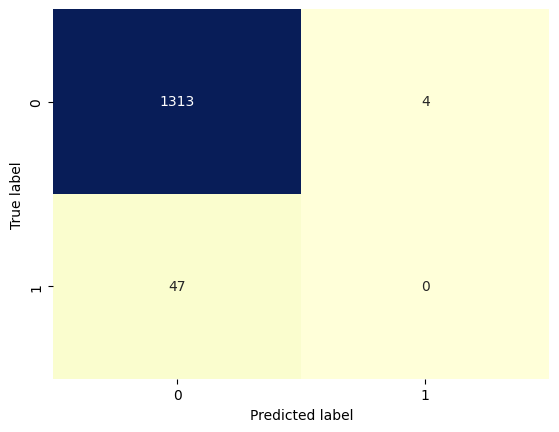

In [6]:
#baseline model
#simple Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

log_reg = LogisticRegression(solver='liblinear', random_state=42)


log_reg.fit(X_train, y_train) #training

y_pred_log_reg = log_reg.predict(X_test) #predicting


accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg) #accuracy
print(f"Logistic Regression Accuracy: {accuracy_log_reg:.4f}")


print("\nClassification Report:") #classification report
print(classification_report(y_test, y_pred_log_reg))


print("\nConfusion Matrix:")#confusion matrix
print(confusion_matrix(y_test, y_pred_log_reg))

cm = confusion_matrix(y_test, y_pred_log_reg)
sns.heatmap(cm, annot=True, cmap="YlGnBu", fmt='d', cbar=False) #plot conf matrix
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [30]:
# Outliers removal

def outliers_removal(feature,feature_name,dataset):
    
    # Identify 25th & 75th quartiles

    q25, q75 = np.percentile(feature, 25), np.percentile(feature, 75)
    # print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
    feat_iqr = q75 - q25
    # print('iqr: {}'.format(feat_iqr))
    
    feat_cut_off = feat_iqr * 1.5
    feat_lower, feat_upper = q25 - feat_cut_off, q75 + feat_cut_off
    # print('Cut Off: {}'.format(feat_cut_off))
    # print(feature_name +' Lower: {}'.format(feat_lower))
    # print(feature_name +' Upper: {}'.format(feat_upper))
    
    outliers = [x for x in feature if x < feat_lower or x > feat_upper]
    # print(feature_name + ' outliers for close to bankruptcy cases: {}'.format(len(outliers)))
    #print(feature_name + ' outliers:{}'.format(outliers))

    dataset = dataset.drop(dataset[(dataset[feature_name] > feat_upper) | (dataset[feature_name] < feat_lower)].index)
    # print('-' * 65)
    
    return dataset

for col in df:
    new_df = outliers_removal(df[col],str(col),df)

In [48]:
# Dividing Data and Labels
y1 = new_df['Bankrupt?']
X1 = new_df.drop(['Bankrupt?'], axis = 1)

In [53]:
y1.shape

(6270,)

In [50]:
X1.shape

(6270, 95)

In [54]:
def log_transform(df):
    
    for col in df:
        skew = df[col].skew()
        if skew > 0.5 or skew < -0.5:
            df[col] = np.log1p(df[col])
        else:
            continue
            
    return df

data_norm = log_transform(X1)

In [55]:
X1.shape

(6270, 95)

In [56]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1,test_size=0.2)

In [57]:
print(X_train1.shape, X_test1.shape, y_train1.shape, y_test1.shape)

(5016, 95) (1254, 95) (5016,) (1254,)


In [58]:
from imblearn.over_sampling import SMOTE
#Smote Before Feature selection
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train1, y_train1)

In [59]:
# Count the occurrences of each class in the original training set
original_class_counts = y_train1.value_counts()
print("Original Training Set Class Counts:")
print(original_class_counts)

# Count the occurrences of each class in the SMOTE-resampled training set
smote_class_counts = y_train_smote.value_counts()
print("\nSMOTE-Resampled Training Set Class Counts:")
print(smote_class_counts)

Original Training Set Class Counts:
0    4833
1     183
Name: Bankrupt?, dtype: int64

SMOTE-Resampled Training Set Class Counts:
0    4833
1    4833
Name: Bankrupt?, dtype: int64


In [60]:
print(X_train_smote.shape, y_train_smote.shape, X_test1.shape, y_test1.shape)

(9666, 95) (9666,) (1254, 95) (1254,)


In [61]:
#scaling before PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test1)

In [64]:
print(X_train_scaled.shape, X_test_scaled.shape, y_train_smote.shape, y_test1.shape)

(9666, 95) (1254, 95) (9666,) (1254,)


In [65]:
explained_variance_ratio = 0.95
pca = PCA(n_components=explained_variance_ratio)
pca.fit(X_train_scaled)

PCA(n_components=0.95)

In [66]:
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [67]:
X_train_pca.shape 

(9666, 45)

In [68]:
y_train_smote.shape

(9666,)

Logistic Regression Accuracy: 0.8565

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.86      0.92      1219
           1       0.13      0.71      0.22        35

    accuracy                           0.86      1254
   macro avg       0.56      0.79      0.57      1254
weighted avg       0.97      0.86      0.90      1254


Confusion Matrix:
[[1049  170]
 [  10   25]]


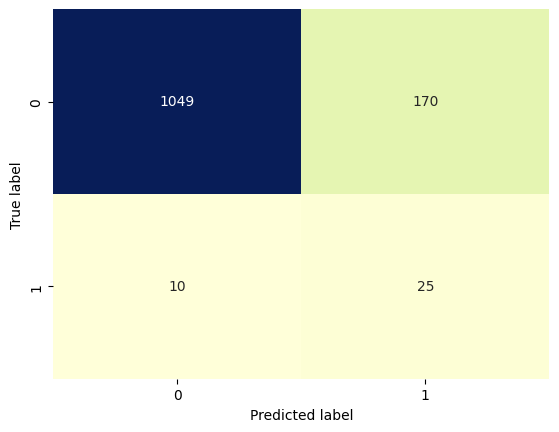

In [69]:
#Logistic Model #1
#logreg after SMOTE oversampling, outlier removal, and PCA (95% variance of features)

log_reg = LogisticRegression(solver='liblinear', random_state=42)

log_reg.fit(X_train_pca, y_train_smote) #training

y_pred_log_reg1 = log_reg.predict(X_test_pca) #predicting


accuracy_log_reg = accuracy_score(y_test1, y_pred_log_reg1) #accuracy
print(f"Logistic Regression Accuracy: {accuracy_log_reg:.4f}")


print("\nClassification Report:") #classification report
print(classification_report(y_test1, y_pred_log_reg1))


print("\nConfusion Matrix:")#confusion matrix
print(confusion_matrix(y_test1, y_pred_log_reg1))

cm1 = confusion_matrix(y_test1, y_pred_log_reg1)
sns.heatmap(cm1, annot=True, cmap="YlGnBu", fmt='d', cbar=False) #plot conf matrix
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Comment:


In [70]:
#Now let's try with undersampling (outliers are removed already)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X1, y1,test_size=0.2)

In [71]:
print(X_train2.shape, X_test2.shape, y_train2.shape, y_test2.shape)

(5016, 95) (1254, 95) (5016,) (1254,)


In [72]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)

In [73]:
X_train_resampled, y_train_resampled = rus.fit_resample(X_train2, y_train2)

In [74]:
# Count the occurrences of each class in the original training set
original_class_counts = y_train2.value_counts()
print("Original Training Set Class Counts:")
print(original_class_counts)

# Count the occurrences of each class in the SMOTE-resampled training set
resampled_class_counts = y_train_resampled.value_counts()
print("\nSMOTE-Resampled Training Set Class Counts:")
print(resampled_class_counts)

Original Training Set Class Counts:
0    4837
1     179
Name: Bankrupt?, dtype: int64

SMOTE-Resampled Training Set Class Counts:
0    179
1    179
Name: Bankrupt?, dtype: int64


In [75]:
#scaling before PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled1 = scaler.fit_transform(X_train_resampled)
X_test_scaled1 = scaler.transform(X_test2)

In [76]:
explained_variance_ratio = 0.95
pca = PCA(n_components=explained_variance_ratio)
pca.fit(X_train_scaled1)

PCA(n_components=0.95)

In [77]:
X_train_pca1 = pca.transform(X_train_scaled1)
X_test_pca1 = pca.transform(X_test_scaled1)

Logistic Regression Accuracy: 0.8437

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.84      0.91      1215
           1       0.14      0.82      0.25        39

    accuracy                           0.84      1254
   macro avg       0.57      0.83      0.58      1254
weighted avg       0.97      0.84      0.89      1254


Confusion Matrix:
[[1026  189]
 [   7   32]]


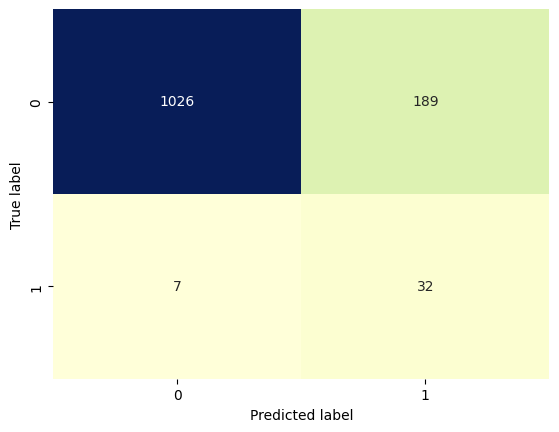

In [78]:
#Logistic Model #2
#logreg after Undersampling, outlier removal, and PCA (95% variance of features)

log_reg = LogisticRegression(solver='liblinear', random_state=42)

log_reg.fit(X_train_pca1, y_train_resampled) #training

y_pred_log_reg2 = log_reg.predict(X_test_pca1) #predicting


accuracy_log_reg = accuracy_score(y_test2, y_pred_log_reg2) #accuracy
print(f"Logistic Regression Accuracy: {accuracy_log_reg:.4f}")


print("\nClassification Report:") #classification report
print(classification_report(y_test2, y_pred_log_reg2))


print("\nConfusion Matrix:")#confusion matrix
print(confusion_matrix(y_test2, y_pred_log_reg2))

cm1 = confusion_matrix(y_test2, y_pred_log_reg2)
sns.heatmap(cm1, annot=True, cmap="YlGnBu", fmt='d', cbar=False) #plot conf matrix
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()